# Category Classification
The goal of this jupyter notebook is to try to predict the uveitis category of a patient based on lab test results. 

The hypothesis is that some lab tests results are indicative of a certain category of uveitis compared to other categories. This is to ascertain (or deny) that a or combination of lab result/s can be significant of which category of uveitis the patient is suffering from. 

Steps:
    
    
1. Get Subset of Data (Target Feature: Category, Input Features: Lab Results) 
2. Call preprocessing pipe with appropriate parameters
3. Fit Model
4. Extract and Discuss important Features



In [1]:
# global Variables
RANDOM = 43

In [2]:
#import packages
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn

# sklearn standard imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Binarizer, LabelEncoder, Normalizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# import decision tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, f1_score, make_scorer

#imblearn processes
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# import of pipe module
os.chdir('../preprocessing/')
import pipe

## Data Preparation
To predict the category of an inflammation, we need to drop all columns that contain information about the category itself. Meta-Information about the patient is also  dropped.

In [18]:
# calling preprocessing function

# num_to_cat = True: Range Date is now dtype Category 
# drop_filter: first method keep all, second drop not lab results

df = pipe.preprocessing_pipe(
                             num_to_cat   = False,
                             #drop_filter  = ['hla', 'specific_diagnosis'], 
                             #drop_filter  = ['hla', 'loc', 'specific_diagnosis'], 
                             drop_filter  = ['hla', 'ac_', 'vit_', 'gender', 'race', 'loc','specific_diagnosis'],
                             loc_approach = 'multi',
                             binary_cat   = True
                             #hotencode_gender = True,
                             #hotencode_race = True
                            ) 

df

,cat,calcium,lactate_dehydrogenase,"c-reactive_protein,_normal_and_high_sensitivity",wbc,rbc,hemoglobin,hematocrit,mcv,mch,...,anti-ena_screen,antinuclear_antibody,complement_c3,complement_c4,dna_double-stranded_ab,rheumatoid_factor,hbc__ab,hbs__ag,hcv__ab,uveitis
0,not_uveitis,2.27,184,1.830,6.91,4.97,14.6,41.4,83.3,29.4,...,0.0,0.0,149.0,33.0,0.0,0,0,0,0,False
1,idiopathic,2.32,209,0.150,4.24,4.22,11.0,36.0,85.3,26.1,...,0.0,0.0,130.8,22.8,0.0,0,0,0,0,True
2,systemic,2.44,194,0.137,6.38,4.31,13.6,38.7,89.8,31.6,...,0.0,0.0,135.9,18.2,0.0,0,0,0,0,True
3,idiopathic,2.45,156,3.500,5.24,4.82,14.6,43.6,90.5,30.3,...,0.0,0.0,130.0,19.9,0.0,0,0,0,0,True
4,idiopathic,2.28,175,1.000,8.31,4.72,14.0,40.7,86.2,29.7,...,0.0,0.0,130.4,19.0,1.0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,infectious,2.26,194,15.400,7.22,5.49,12.7,40.6,74.0,23.1,...,0.0,0.0,112.4,36.1,0.0,0,0,0,0,True
1071,idiopathic,2.36,239,0.800,7.65,4.56,12.6,35.9,78.7,27.6,...,0.0,0.0,121.5,22.3,0.0,0,0,0,0,True
1072,infectious,2.26,196,0.600,3.83,4.54,14.5,42.8,94.3,31.9,...,0.0,0.0,114.9,24.6,0.0,0,0,0,0,True
1073,wds,2.41,173,6.970,16.65,4.94,13.4,40.5,82.0,27.1,...,0.0,0.0,131.0,26.0,0.0,0,0,0,0,True



Small check to controll if any missing values in the target are present and accertain weighting of categories

In [19]:
print("missing in target are", df['cat'].isnull().sum())

missing in target are 0


idiopathic                  0.493482
systemic                    0.178771
not_uveitis                 0.131285
wds                         0.115456
infectious                  0.081006
scleritis                   0.000000
nonneoplastic masquerade    0.000000
neoplastic masquerade       0.000000
Name: cat, dtype: float64

#### Train-Test Split
Trainingset contains 75% of data. The target feature is the cat (category)-Feature. 
The target feature contains 0 missing values

In [20]:
# train-test split
df_t = df.copy().dropna()
features = df_t.drop(columns=['cat', 'uveitis']) # all features excluded target
target = df_t['cat'].cat.codes # target

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state = RANDOM, stratify = None)
scorer = make_scorer(f1_score, average = 'macro')

In [23]:
percentil_cat = df.cat.value_counts(dropna=False)/len(df)
percentil_cat

idiopathic                  0.493482
systemic                    0.178771
not_uveitis                 0.131285
wds                         0.115456
infectious                  0.081006
scleritis                   0.000000
nonneoplastic masquerade    0.000000
neoplastic masquerade       0.000000
Name: cat, dtype: float64

**Discussion** The above percentages show the distribution of the target feature. Balacing them will be paramount, as DecisionTree do not like unbalanced data

#### Imputation and Encoding

In [25]:
# filter for numeric and categorical features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
category = ['category','bool']

# select list of numeric and categorical features
numeric_features = features.select_dtypes(include=numerics).columns.tolist()
categorical_features = features.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot = False)

## Decision Tree

Accuracy: 0.23821402269306313
              precision    recall  f1-score   support

           0       0.61      0.41      0.49        90
           1       0.24      0.25      0.24        20
           4       0.11      0.16      0.13        19
           6       0.14      0.18      0.16        22
           7       0.13      0.24      0.17        17

    accuracy                           0.32       168
   macro avg       0.25      0.25      0.24       168
weighted avg       0.40      0.32      0.34       168

{'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 12}


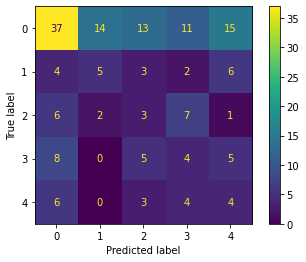

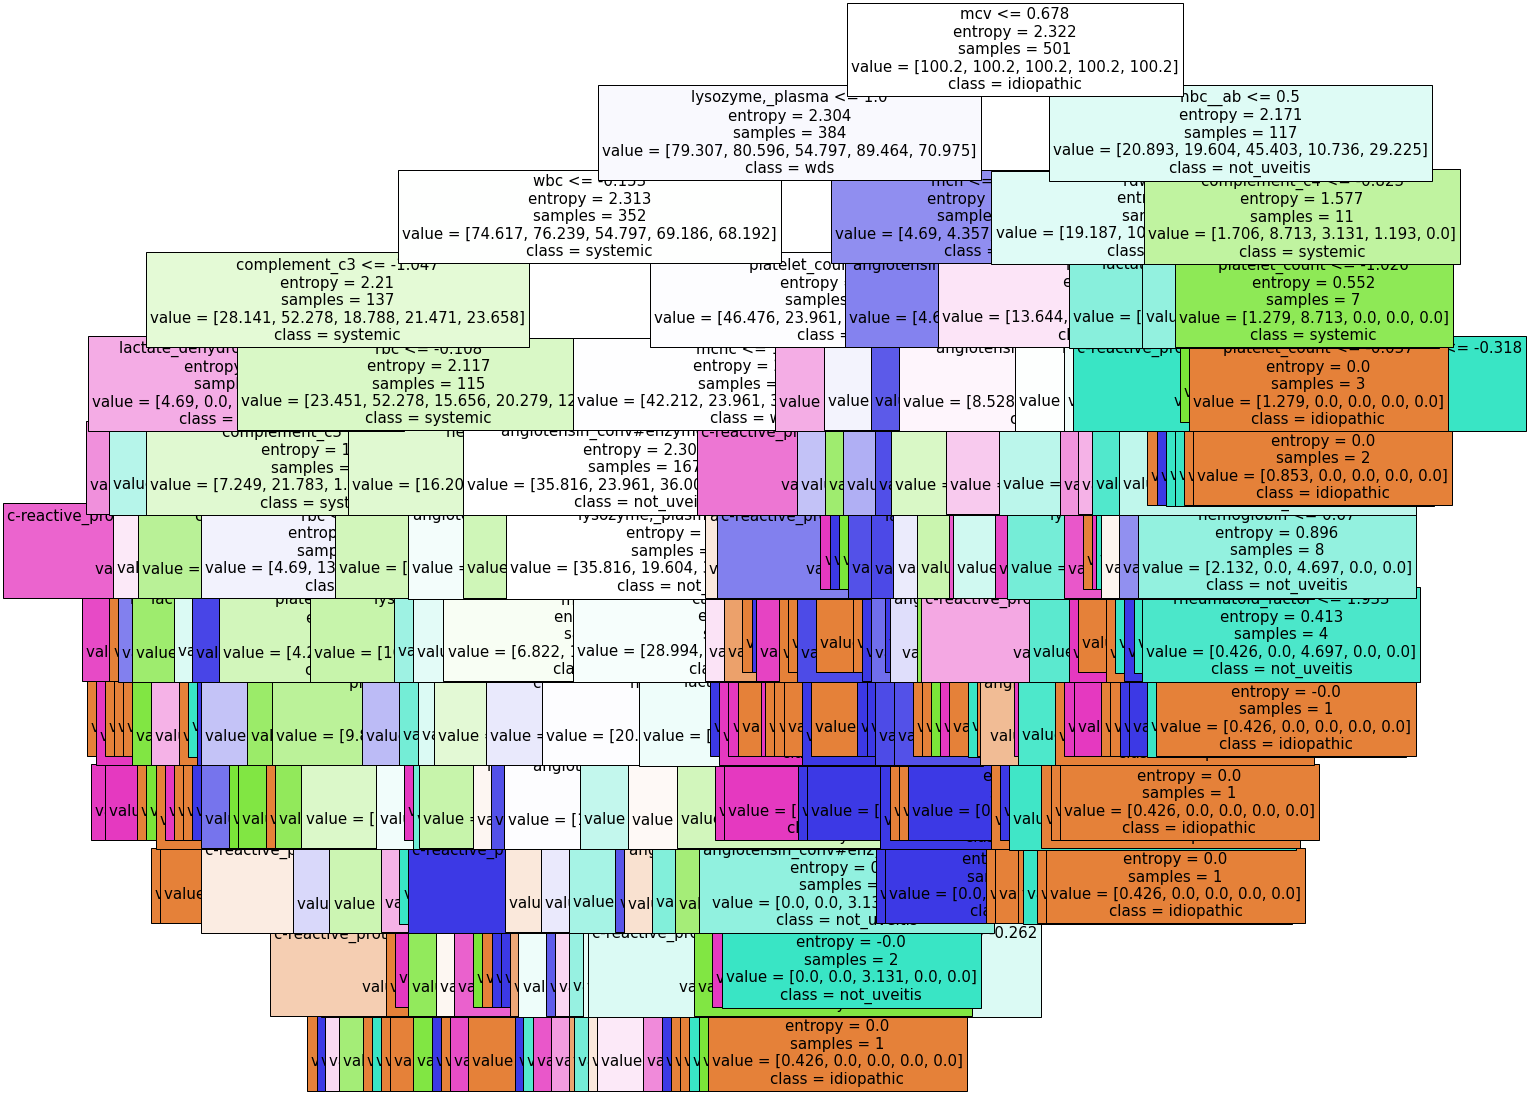

In [22]:
#dectree = DecisionTreeClassifier()

pipeline = Pipeline(steps=[('preprocessor', imputer_encoder),
                      ('classifier', dectree)])

criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
class_weight = ["balanced"] #[{"idiopathic":0.49, "systemic":0.18, "not_uveitis":0.13, "wds":0.12, "infectious":0.08}]

parameters = {
             'classifier__criterion':criterion,
             'classifier__max_depth':max_depth,
             'classifier__class_weight':class_weight
             }

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, parameters, cv = 10, scoring = scorer)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: target_pred
target_pred = cv.predict(X_test)

# Compute and print metrics
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, target_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, target_pred)).plot();
print(cv.best_params_);

plt.figure(figsize=(20,20))
class_names = ['idiopathic', 'systemic', 'not_uveitis', 'wds', 'infectiuos']
feature_names = X_test.columns.tolist()
plot_tree(cv.best_estimator_[1], fontsize=15, class_names=class_names, feature_names=feature_names, filled=True)
plt.show()

Looking at the confusion matrix we can observe that most of the prediction fits to 'idiopathic'. This is most probably due to the unbalanced nature of the target data. This also means that the balanced option of class weight either fails for the target or that other factors in the features themselves cause this unbalance

In [26]:
df_over = df.copy().dropna()
X = df_over.drop(columns=['cat', 'uveitis']) # all features excluded target
y = df_over['cat'].cat.codes # target

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = RANDOM, stratify = None)

In [27]:
# filter for numeric and categorical features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
category = ['category','bool']

# select list of numeric and categorical features
numeric_features = X.select_dtypes(include=numerics).columns.tolist()
categorical_features = X.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot = False)

In [28]:
#sorted(sklearn.metrics.SCORERS.keys())

Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

           0       0.60      0.44      0.51        90
           1       0.28      0.25      0.26        20
           4       0.12      0.16      0.13        19
           6       0.13      0.18      0.15        22
           7       0.15      0.24      0.19        17

    accuracy                           0.33       168
   macro avg       0.25      0.25      0.25       168
weighted avg       0.40      0.33      0.36       168

{'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 12}


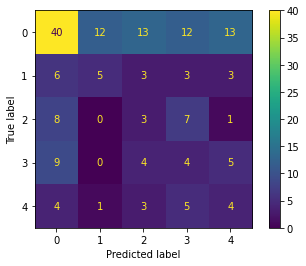

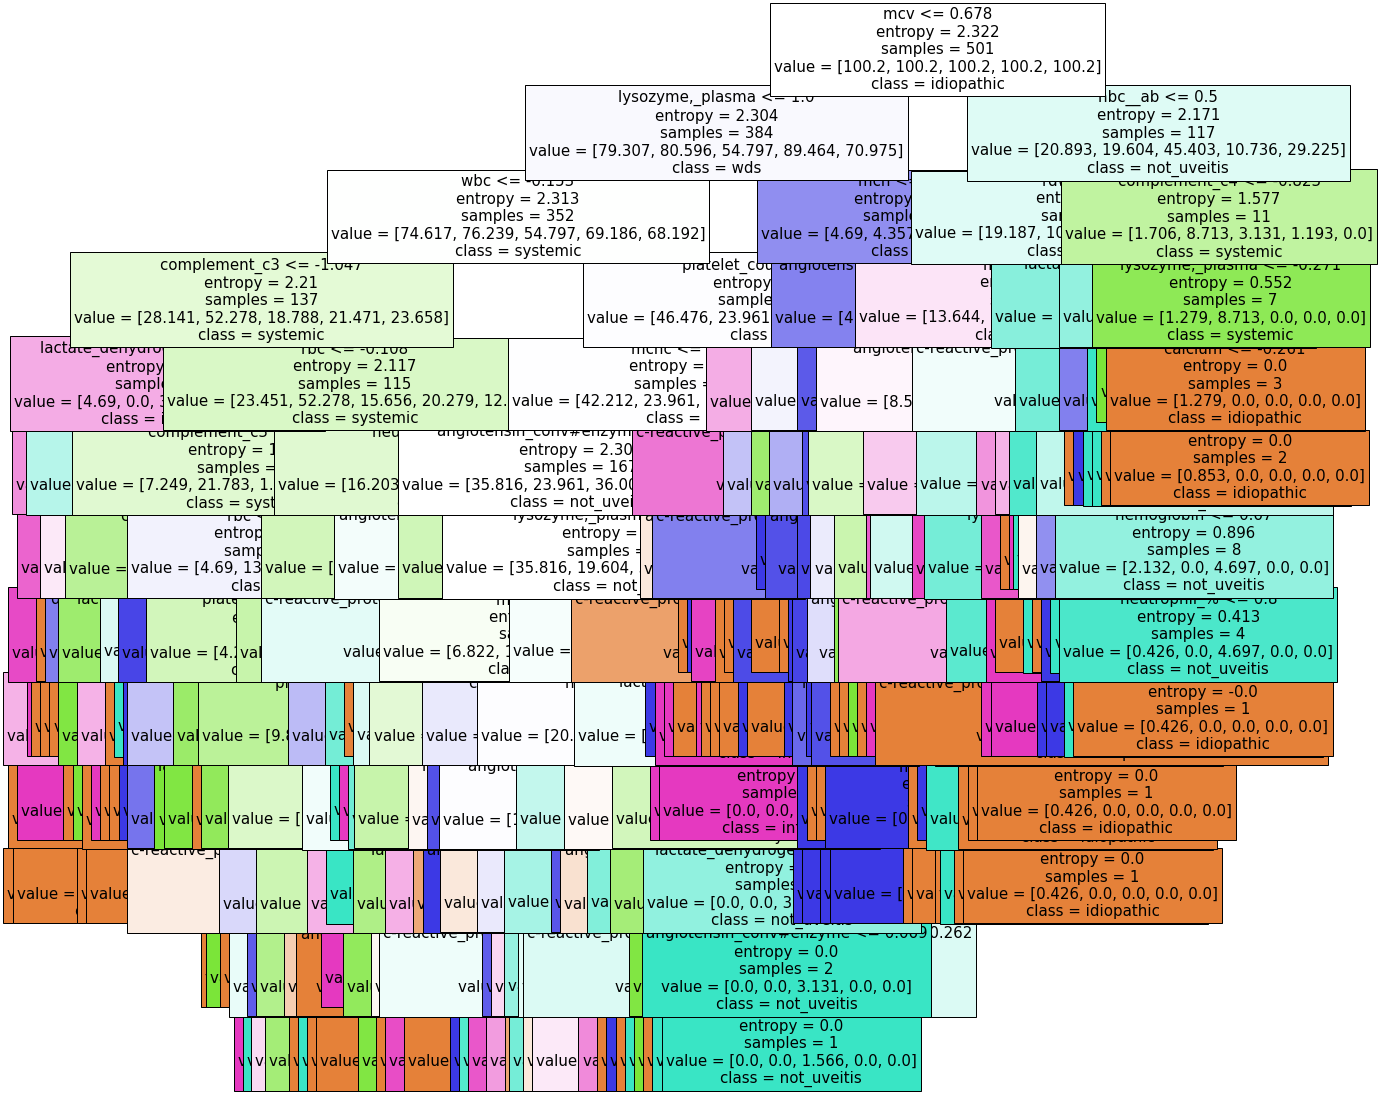

In [29]:
pipeline = Pipeline(steps=[('preprocessor', imputer_encoder),
                      ('classifier', dectree)])

criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
class_weight = ["balanced"] #[{"idiopathic":0.49, "systemic":0.18, "not_uveitis":0.13, "wds":0.12, "infectious":0.08}]

parameters = {
             'classifier__criterion':criterion,
             'classifier__max_depth':max_depth,
             'classifier__class_weight':class_weight
             }

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, parameters, cv = 10)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: target_pred
target_pred = cv.predict(X_test)

# Compute and print metrics
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, target_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, target_pred)).plot();
print(cv.best_params_);

plt.figure(figsize=(20,20))
class_names = ['idiopathic', 'systemic', 'not_uveitis', 'wds', 'infectiuos']
feature_names = X_test.columns.tolist()
plot_tree(cv.best_estimator_[1], fontsize=15, class_names=class_names, feature_names=feature_names, filled=True)
plt.show()